In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch


from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from nupic.research.frameworks.continuous_learning.correlation_metrics import register_act, plot_metrics
from nupic.research.frameworks.continuous_learning.utils import get_act, dc_grad

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def clear_labels(labels):
    indices = np.arange(11)
    out = np.delete(indices, labels)
    return out

Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01
Creating optimizer with learning rate= 0.01


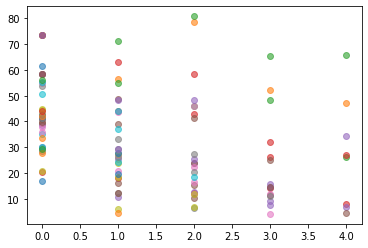

In [4]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)

exp = "sparseCNN2"

layers_ = ["cnn2_kwinner", "linear1_kwinners"]
layer_type = "kwinner"
# layer_type = "dense"

fcs = []

cnn_pct_on = (0.25, 0.125) # default
cnn_weight_sparsity = (0.3, 0.2) # default

cnn_out = 512

train_inds = np.arange(1,11).reshape(5,2)
pcts = [20, 100]
for freeze_pct in np.arange(pcts[0],pcts[1], 20):
    config = config_init[exp]
    config["name"] = exp
    config["seed"] = np.random.randint(0,200)
    config["cnn_out_channels"] = (128, cnn_out)
    config["cnn_percent_on"] = (cnn_pct_on[0], max(cnn_pct_on[1]/(cnn_out/64), 0.02))
    config["cnn_weight_sparsity"] = (cnn_weight_sparsity[0], max(cnn_weight_sparsity[1]/(cnn_out/64), 0.02))
                                

    if layer_type == "kwinner":
        config["linear_n"] = (1000,11)
        config["linear_percent_on"] = (0.1, 0.1)
        config["weight_sparsity"] = (0.1, 0.2)
    #     layers_.extend(["linear2_kwinners"])


    config["batch_size"] = 64    
    config["boost_strength"] = 0.0
    config["boost_strength_factor"] = 0.0
    config["duty_cycle_period"] = 1000

    experiment = ContinuousSpeechExperiment(config)

    if layer_type == "dense":
        experiment.model.add_module("output", torch.nn.Linear(1000, 11).cuda())

    freeze_params=layers_

    for j in range(len(train_inds)):

        if j == 0:
            experiment.train(1,train_inds[j],
                            freeze_output=True,
                            layer_type=layer_type,
                            output_indices=clear_labels(train_inds[j]))
        else:
            experiment.train(2,train_inds[j],freeze_params=freeze_params,
                            freeze_fun=dc_grad,
                            freeze_pct=freeze_pct,
                            freeze_output=True,
                            layer_type=layer_type,
                            output_indices=clear_labels(train_inds[j]))

    fc = experiment.get_forgetting_curve()
    fcs.append(fc)

    plt.plot(fc,'o', alpha=0.6);

In [96]:
np.save("../saved_data/size{}_boost{}_dc_pct{}:{}_{}_dcp{}.pdf".format(config["cnn_out_channels"][1],
                                                           int(config["boost_strength"]),
                                                           layer_type,
                                                           pcts[0],pcts[1],
                                                           int(config["duty_cycle_period"])), fcs)

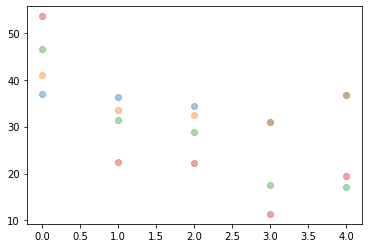

In [8]:
[plt.plot(np.nanmean(k, axis=1), 'o', alpha=0.4) for k in fcs];

# plt.legend(np.arange(50,100, 5))

In [6]:
from sklearn.linear_model import LinearRegression
def linear_fit(fcs):
    cs = []
    ics = []
    lr = LinearRegression()
    x = np.arange(5).reshape(-1,1)
    for ind in range(len(fcs)):
        lr.fit(x, np.nanmean(fcs[ind], axis=1))
        c = lr.coef_.mean()
        ic = lr.intercept_.mean()
        
        cs.append(c)
        ics.append(ic)
        
    return np.array(cs), np.array(ics)

ValueError: x and y must have same first dimension, but have shapes (10,) and (4,)

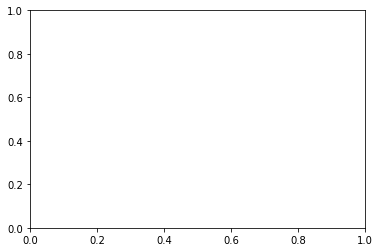

In [7]:
a, b = linear_fit(fcs)
plt.plot(np.arange(50,100, 5), a)
plt.xlabel("dc freeze pct")
plt.ylabel("slope of linear fit")
plt.savefig("../plots/duty_cycle_freezing_period_{}_layer_dcp{}_128_{}.pdf".format(
                                                                            layer_type,
                                                                            config["duty_cycle_period"],
                                                                            config["cnn_out_channels"][1])
           )

In [60]:
yn.shape

(5, 10)

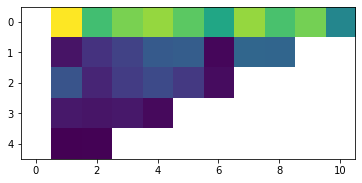

In [95]:
plt.imshow(fc)

In [202]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
train_inds = np.arange(1,11).reshape(5,2)

exp = "denseCNN2"
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["cnn_out_channels"] = (256, 256)
layer_type="dense"


experiment = ContinuousSpeechExperiment(config)
experiment.model.add_module("output", torch.nn.Linear(1000, 11).cuda())


for j in range(len(train_inds)):

        experiment.train(1,train_inds[j],
                        freeze_output=True,
                        layer_type=layer_type,
                        output_indices=clear_labels(train_inds[j]))

Creating optimizer with learning rate= 0.01


In [200]:
experiment.model.add_module("output", torch.nn.Linear(1000, 11))

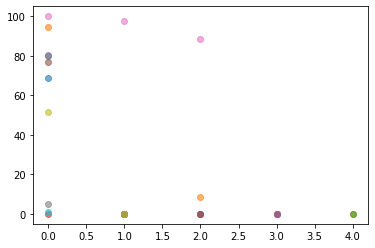

In [203]:
fc = experiment.get_forgetting_curve()
np.save("../saved_data/size{}_dense.pdf".format(config["cnn_out_channels"][0],
                                                           ), fc)

plt.plot(fc,'o', alpha=0.6);

In [6]:
layers_.extend(["linear2_kwinners"])

In [19]:
a = torch.squeeze(experiment.get_duty_cycles()["cnn1_kwinner"])

In [28]:
inds = [10, 122, 436]
a[inds] = 0.0
b = torch.squeeze(a[a.nonzero()])

In [42]:
# def dc_grad(model, kwinner_modules, duty_cycles, frozen_dcs=None, pct=90):
model = experiment.model
duty_cycles = experiment.get_duty_cycles()
kwinner_modules = ["cnn1_kwinner"]
frozen_dcs = [8,23,234]
pct = 90

all_modules = list(model.named_children())
# module_dict = {k[0]: k[1] for k in all_modules}

for module_name in kwinner_modules:
    if "kwinner" not in module_name:
        print(module_name)
        raise RuntimeError("Not a k-winner module")
    else:
        # module = module_dict[module_name]
        dc = torch.squeeze(duty_cycles[module_name])
        if frozen_dcs is not None:
            dc[frozen_dcs] = 0.0

        k = int((1 - pct / 100) * len(dc))
        _, inds = torch.topk(dc, k)

    module_num = module_name.split("_")[0][-1]
    module_type = module_name.split("_")[0][:-1]

    # find the module corresponding to the kwinners
    if module_type == "cnn":
        module_index = int(np.where(["cnn{}_cnn".format(module_num) in k[0]
                                     for k in all_modules])[0])
    elif module_type == "linear":
        module_index = int(np.where(["linear{}".format(module_num) in k[0]
                                     for k in all_modules])[0][0])

    weight_grads, bias_grads = [k.grad
                                for k in all_modules[module_index][1].parameters()]



In [32]:
duty_cycles = experiment.get_duty_cycles()["cnn1_kwinner"]
fdcs = torch.squeeze(duty_cycles)

In [56]:
experiment.frozen_inds

tensor([[-1.4099e-04,  5.0257e-06, -3.2329e-04,  ..., -2.9835e-04,
         -4.4993e-04, -9.5940e-04],
        [ 3.8266e-04,  2.7763e-04,  2.8247e-04,  ...,  1.1724e-06,
         -3.3919e-04,  2.5748e-05],
        [ 4.4514e-04, -8.4291e-05,  2.7577e-04,  ..., -5.4569e-05,
         -1.0449e-04, -1.4468e-04],
        ...,
        [ 3.1372e-04,  3.7986e-04,  1.2278e-04,  ..., -5.5801e-06,
          2.2010e-04,  3.7797e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.0155e-04,  4.9811e-04, -1.3289e-03,  ...,  2.2856e-04,
          1.2035e-04,  3.4209e-05]], device='cuda:0')

In [13]:
fc.shape

(5, 11)

In [58]:
j

2